# Test the two-line CLEDB inversion on synthetic CLE data.

In [1]:
## the script version "test_2line.py" is generated by exporting this notebook via file -> export as -> executable script.
## Do not directly edit that version!

<Figure size 1080x1080 with 0 Axes>

In [2]:
## Needed modules
import pickle                ## CLE synthetic observation data cube is saved in the pickle format.
import importlib             ## reloads imports (python default settings will not reload small changes).

from numba.typed import List ## Most numba functions are loaded by the CLEDB modules; non-reflected lists are needed to create a list of 2 bservation arrays

## Inversion Constants and control parameter imports.
## symbolic links pointing to the root directory containing the files are used. Pythondoes not allow relative upstream references anymore
import constants as consts
import ctrlparams 
params=ctrlparams.ctrlparams()    ## just a shorter label

### 1. Import the synthetic CLE observation.

In [3]:
## observations of a 3 dipole coronal structure of a Fe XIII combined observation
## sobs1-3 are the independent dipoles
## sobsa is the combined 3 dipole output
## waveA and waveB are the wavelength arrays for the two Fe XIII lines

# with open('obsstokes_3dipole_hires_fullspectra.pkl','rb') as f:
#     sobs1,sobs2,sobs3,sobsa,waveA,waveB = pickle.load(f)  
# ### reversing of the wavelength range. THIS IS NEEDED! CLE writes frequency-wise, so wavelengths are reversed in the original datacubes!!!!!!
# sobs1=sobs1[:,:,::-1,:]   
# sobs2=sobs2[:,:,::-1,:]
# sobs3=sobs3[:,:,::-1,:]
# sobsa=sobsa[:,:,::-1,:]
# waveA=waveA[::-1]
# waveB=waveB[::-1]
# ## we test here using sobs1.

In [4]:
## load the fake observation muram data.
## FE XIII 1074+1079

with open('obsstokes_avg_muram3.pkl','rb') as f:
    sobsa = pickle.load(f) 
sobsa=sobsa[0]  

### 2. Test the CLEDB_PREPINV module with synthetic data. 

##### Remember to set your personal options and database paths in the ctrlparams class (in the parent directory) before continuing.

In [5]:
import CLEDB_PREPINV.CLEDB_PREPINV as prepinv  ##imports from the CLEDB_PREPINV subdirectory

In [6]:
## arrange the two observation "files" in a simple list;
## un-necesary step given the shape of sobs array, but it mimicks a file/header structure.

## set a proper numba typed list
sobs_lst=[sobsa[:,:,:,0:4],sobsa[:,:,:,4:8]]  ## standard python lists will be deprecated ; they do not work well with numba
sobs_in = List()                              ## this is the List object implemented by numba; It utilizes memory in a column-like fashion.
[sobs_in.append(x) for x in sobs_lst]         ## Numba developers claim that it is a significantly faster performing object

[None, None]

##### preprocess the observation "files"

In [7]:
# importlib.reload(prepinv)       ## If module is modified, reload the contents

sobs_tot,yobs,rms,background,keyvals,sobs_totrot,aobs=prepinv.sobs_preprocess(sobs_in,params)

------------------------------------
--------OBS PROCESSING START--------
------------------------------------
We are inverting observations of 2 coronal line(s) 
Line 1: Fe XIII 1074.7nm
Line 2: Fe XIII 1079.8nm
------------------------------------
-----OBS PREPROCESS FINALIZED-------
------------------------------------


In [39]:
## select and pre-read the database files based on the observation preprocessing
## At this point, the database should be generated and properly linked.

importlib.reload(prepinv)       ## If module is modified, reload the contents
db_enc,database,dbhdr=prepinv.sdb_preprocess(yobs,keyvals,params)
## Warning, this might be memory consuming; see details in documentation

------------------------------------
----------DB READ START-------------
------------------------------------
CLEDB covers a span of 14 heights between 1.001 - 1.47 Solar radius
Load DB datafiles for 3  heights in memory for 2 line(s).
------------------------------------
INDIVIDUAL DB file location: /home/alin/Documents/physics_prog/cle/test_cle_degeneracy/db202_R0500/fe-xiii_1074/DB0001.DAT
INDIVIDUAL DB file location: /home/alin/Documents/physics_prog/cle/test_cle_degeneracy/db202_R0500/fe-xiii_1079/DB0001.DAT
INDIVIDUAL DB file location: /home/alin/Documents/physics_prog/cle/test_cle_degeneracy/db202_R0500/fe-xiii_1074/DB0070.DAT
INDIVIDUAL DB file location: /home/alin/Documents/physics_prog/cle/test_cle_degeneracy/db202_R0500/fe-xiii_1079/DB0070.DAT
INDIVIDUAL DB file location: /home/alin/Documents/physics_prog/cle/test_cle_degeneracy/db202_R0500/fe-xiii_1074/DB0020.DAT
INDIVIDUAL DB file location: /home/alin/Documents/physics_prog/cle/test_cle_degeneracy/db202_R0500/fe-xiii_1079

##### At this point all necesary data and required databases are loaded into memory for fast processing

### 3. Test the CLEDB_PROC module with the same synthetic data.

In [9]:
import CLEDB_PROC.CLEDB_PROC as procinv

##### Process the spectroscopy outputs

In [11]:
#importlib.reload(procinv)       ## If module is modified, reload the contents 
specout=procinv.spectro_proc(sobs_in,sobs_tot,rms,background,keyvals,consts,params)      ## when storing to disk do an if to reduce dimensions for 1 line cases

#####Process the LOS magnetic fields from the first line

In [ ]:
#importlib.reload(procinv)       ## If module is modified, reload the contents 
blosout=procinv.blos_proc(sobs_tot[:,:,0:4],rms[:,:,0:4],keyvals,consts,params)

##### Process the full vector magnetic field inversion products

In [ ]:
importlib.reload(procinv)       ## If module is modified, reload the contents
invout,sfound=procinv.cledb_invproc(sobs_totrot,database,db_enc,yobs,aobs,rms,dbhdr,keyvals,params.nsearch,params.maxchisq,params.bcalc,params.reduced,params.verbose)
## WARNING: This step has a significantly long execution time.

--------------------------------------
CLEDB_IVPROC: TWO LINE INVERSION START
--------------------------------------
CLEDB_INVPROC: Executing ext. loop: 0  of  1024  ( 1024  calculations / loop)
CLEDB_INVPROC: Executing ext. loop: 1  of  1024  ( 1024  calculations / loop)
CLEDB_INVPROC: Executing ext. loop: 2  of  1024  ( 1024  calculations / loop)


##### All should be good if we reached this point; all the outputs should be computed.

### 4. DUMP results (optional)

In [8]:
from datetime import datetime
import os
import glob

## Remove old file saves and keep just the last run
lst=glob.glob('./outparams_2line*.pkl')
if len(lst) >0:
    for i in range(len(lst)):
        os.remove(lst[i])
        
## save the last run 
datestamp = datetime.now().strftime("%Y%m%d-%H:%M:%S")        
with open(f'outparams_2line_{datestamp}.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([specout,blosout,invout,sfound], f)

### 5. PLOT the outputs (optional)

In [31]:
##needed libraries and functions
from matplotlib import pyplot as plt
## interactive plotting; use only on local machines if installed
%matplotlib widget                

# colorbar function to have nice colorbars in figures with title
def colorbar(mappable,*args,**kwargs):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax,format='%.2f')
    #cbar.formatter.set_powerlimits((0, 0))
    title= kwargs.get('title', None)
    cbar.set_label(title)
    plt.sca(last_axes)
    return cbar



In [ ]:
## Plot utils

linen=0                ## Specout: choose which line to plot; range is [0:1] for 2 line input
soln=3                 ## Invout: which solution to plot; range is [0:nsearch-1] where nsearch is defined in ctrlparams
## plot subranges for soome in snapshots
# ## 3dipole
# srx1=230
# srx2=400
# sry1=65
# sry2=195
#rnge=[0.8,1.5,-1.1,1.1]

##muram
srx1=0
srx2=1023
sry1=0
sry2=1023
rnge=[0.989,1.060,-0.071,0.071]


NameError: name 'specout' is not defined

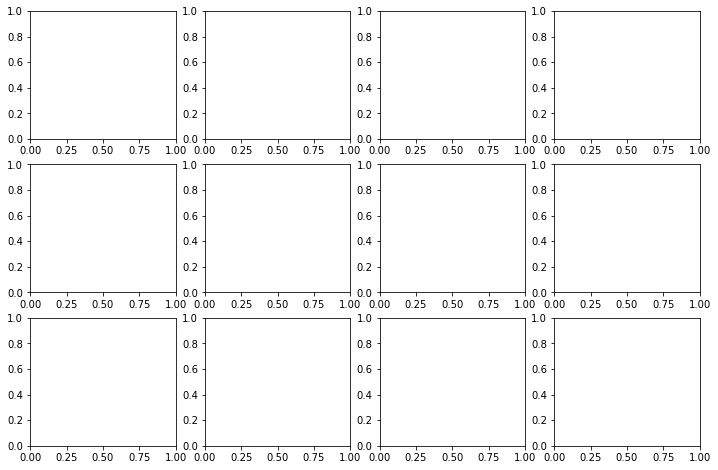

In [2]:
##Plot spectroscopy

fig, plots = plt.subplots(nrows=3, ncols=4, figsize=(12,10))

## remove the 0 values and unreasonable/outlier values.
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,0], mask=specout[srx1:srx2,sry1:sry2,linen,0]==0)
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,0]>= 3950)
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,0]<= 1070)
vvmin=np.min(mx)
vvmax=np.max(mx)
ab=plots[0,0].imshow(specout[srx1:srx2,sry1:sry2,linen,0],extent=rnge,vmin=vvmin,vmax=vvmax,cmap='bone')
plots[0,0].set_title('Wavelength')
colorbar(ab,title="[nm]")
plots[0,0].set_ylabel('Z [R$_\odot$]')
#plots[0,0].set_xlabel('Y [R$_\odot$]')
############################################################

## for correctly scaling in doppler scales
## remove unreasonable/outlier values.
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,1], mask=specout[srx1:srx2,sry1:sry2,linen,1]>= 2 )
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,1]<= -2 )
vvmax=np.max(mx)
vvmin=np.min(mx)
if np.abs(vvmin) >  np.abs(vvmax):
    vr=np.abs(vvmin)
else:
    vr=np.abs(vvmax)
ab=plots[0,1].imshow(specout[srx1:srx2,sry1:sry2,linen,1],extent=rnge,vmin=-vr,vmax=vr,cmap='seismic')
plots[0,1].set_title('Doppler shift')
colorbar(ab,title="[nm]")
#plots[0,1].set_ylabel('Z [R$_\odot$]')
#plots[0,1].set_xlabel('Y [R$_\odot$]')
############################################################

## for correctly scaling in doppler scales
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,2], mask=specout[srx1:srx2,sry1:sry2,linen,2]>= 1000 )
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,2]<= -1000 )
vvmax=np.max(mx)
vvmin=np.min(mx)
if np.abs(vvmin) >  np.abs(vvmax):
    vr=np.abs(vvmin)
else:
    vr=np.abs(vvmax)
## back to plotting    
ab=plots[0,2].imshow(specout[srx1:srx2,sry1:sry2,linen,2],extent=rnge,vmin=-vr,vmax=vr,cmap='seismic')
plots[0,2].set_title('Doppler shift')
colorbar(ab,title="[km s$^{-1}$]")
#plots[0,2].set_ylabel('Z [R$_\odot$]')
#plots[0,2].set_xlabel('Y [R$_\odot$]')
############################################################


ab=plots[0,3].imshow(specout[srx1:srx2,sry1:sry2,linen,7],extent=rnge,vmin=0,vmax=np.max(specout[srx1:srx2,sry1:sry2,linen,7]),cmap='Reds')
plots[0,3].set_title('Stokes I bkg.')
colorbar(ab,title="Signal [erg cm${-2}$ s$^{-1}$]")
#plots[0,3].set_ylabel('Z [R$_\odot$]')
#plots[0,3].set_xlabel('Y [R$_\odot$]')
############################################################

ab=plots[1,0].imshow(specout[srx1:srx2,sry1:sry2,linen,3],extent=rnge,vmin=0,vmax=np.max(specout[srx1:srx2,sry1:sry2,linen,3]),cmap='Reds')
plots[1,0].set_title('Stokes I int. (linecore)')
colorbar(ab,title="Signal [erg cm${-2}$ s$^{-1}$]")
plots[1,0].set_ylabel('Z [R$_\odot$]')
#plots[1,0].set_xlabel('Y [R$_\odot$]')
############################################################

vvmin=np.min(specout[srx1:srx2,sry1:sry2,linen,4])
vvmax=np.max(specout[srx1:srx2,sry1:sry2,linen,4])
if np.abs(vvmin) >  np.abs(vvmax):
    vr=np.abs(vvmin)
else:
    vr=np.abs(vvmax)
ab=plots[1,1].imshow(specout[srx1:srx2,sry1:sry2,linen,4],extent=rnge,vmin=-vr,vmax=vr,cmap='seismic')
plots[1,1].set_title('Stokes Q int. (linecore)')
colorbar(ab,title="Signal [erg cm${-2}$ s$^{-1}$]")
#plots[1,1].set_ylabel('Z [R$_\odot$]')
#plots[1,1].set_xlabel('Y [R$_\odot$]')
############################################################

vvmin=np.min(specout[srx1:srx2,sry1:sry2,linen,5])
vvmax=np.max(specout[srx1:srx2,sry1:sry2,linen,5])
if np.abs(vvmin) >  np.abs(vvmax):
    vr=np.abs(vvmin)
else:
    vr=np.abs(vvmax)
ab=plots[1,2].imshow(specout[srx1:srx2,sry1:sry2,linen,5],extent=rnge,vmin=-vr,vmax=vr,cmap='seismic')
plots[1,2].set_title('Stokes U int. (linecore)')
colorbar(ab,title="Signal [erg cm${-2}$ s$^{-1}$]")
#plots[1,2].set_ylabel('Z [R$_\odot$]')
#plots[1,2].set_xlabel('Y [R$_\odot$]')
############################################################

vvmin=np.min(specout[srx1:srx2,sry1:sry2,linen,5])
vvmax=np.max(specout[srx1:srx2,sry1:sry2,linen,5])
if np.abs(vvmin) >  np.abs(vvmax):
    vr=np.abs(vvmin)
else:
    vr=np.abs(vvmax)
ab=plots[1,3].imshow(specout[srx1:srx2,sry1:sry2,linen,6],extent=rnge,vmin=-vr,vmax=vr,cmap='seismic')
plots[1,3].set_title('Stokes V int. (linecore)')
colorbar(ab,title="Signal [erg cm${-2}$ s$^{-1}$]")
#plots[1,3].set_ylabel('Z [R$_\odot$]')
#plots[1,3].set_xlabel('Y [R$_\odot$]')
############################################################


## remove unreasonable/outlier values.
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,8], mask=specout[srx1:srx2,sry1:sry2,linen,8]>= 0.45 )
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,8]<= 0.01 )
vvmax=np.max(mx)
vvmin=np.min(mx)

ab=plots[2,0].imshow(specout[srx1:srx2,sry1:sry2,linen,8],extent=rnge,vmin=vvmin,vmax=vvmax,cmap='YlGnBu')
plots[2,0].set_title('Line full width half max.')
colorbar(ab,title="[nm]")
plots[2,0].set_ylabel('Z [R$_\odot$]')
plots[2,0].set_xlabel('Y [R$_\odot$]')
############################################################

## remove unreasonable/outlier values.
## PLOT INSIDE THE SAME SUBRANGES AS FULL WIDTHS TO SHOW THAT THEY ARE FRACTIONS.
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,9], mask=specout[srx1:srx2,sry1:sry2,linen,9]>= 0.35 )
vvmax=np.nanmax(mx)
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,9]<= 0.01 )
vvmin=np.nanmin(mx)

ab=plots[2,1].imshow(specout[srx1:srx2,sry1:sry2,linen,9],extent=rnge,vmin=0.1,vmax=vvmax,cmap='YlGnBu')
plots[2,1].set_title('Line non-thermal width')
colorbar(ab,title="[nm]")
#plots[2,1].set_ylabel('Z [R$_\odot$]')
plots[2,1].set_xlabel('Y [R$_\odot$]')
############################################################


ab=plots[2,2].imshow(specout[srx1:srx2,sry1:sry2,linen,10],extent=rnge,vmin=0.01,vmax=np.max(specout[srx1:srx2,sry1:sry2,linen,10]),cmap='YlOrRd')
plots[2,2].set_title('Linear polarization fraction')
colorbar(ab,title="L / I ratio")
#plots[0,0].set_ylabel('Z [R$_\odot$]')
plots[2,2].set_xlabel('Y [R$_\odot$]')
############################################################


ab=plots[2,3].imshow(specout[srx1:srx2,sry1:sry2,linen,11],extent=rnge,vmin=0.01,vmax=np.max(specout[srx1:srx2,sry1:sry2,linen,11]),cmap='YlOrRd')
plots[2,3].set_title('Total polarization fraction')
colorbar(ab,title="P / I ratio")
#plots[2,3].set_ylabel('Z [R$_\odot$]')
plots[2,3].set_xlabel('Y [R$_\odot$]')
############################################################

plt.tight_layout()

plt.savefig(f"specout_1line_line{linen}_{datestamp}.pdf")

In [23]:
## Plot magnetic inversion

fig, plots = plt.subplots(nrows=4, ncols=3, figsize=(10,12))
ab=plots[0,0].imshow(invout[230:400,65:195,soln,0],vmin=0,vmax=5e7)
plots[0,0].set_title('Database index')
colorbar(ab)

ab=plots[0,1].imshow(invout[230:400,65:195,soln,1],vmin=0,vmax=0.25)
plots[0,1].set_title('Fit $\chi^2$')
colorbar(ab)

plots[0, 2].axis('off') ###leave one empty panel

ab=plots[1,0].imshow(invout[230:400,65:195,soln,2],vmin=1,vmax=10)
plots[1,0].set_title('Plasma density (Log)')
colorbar(ab)

ab=plots[1,1].imshow(invout[230:400,65:195,soln,3],vmin=0.9,vmax=1.5)
plots[1,1].set_title('Computed height (R$_\odot$)')
colorbar(ab)

ab=plots[1,2].imshow(invout[230:400,65:195,soln,4],vmin=-1.5,vmax=1.5)
plots[1,2].set_title('LOS position (R$_\odot$')
colorbar(ab)


ab=plots[2,0].imshow(invout[230:400,65:195,soln,5],vmin=0,vmax=700)
plots[2,0].set_title('LVS field strength')
colorbar(ab)

ab=plots[2,1].imshow(invout[230:400,65:195,soln,6],vmin=0,vmax=6.28)
plots[2,1].set_title('LVS B$_\phi$ [rad]')
colorbar(ab)

ab=plots[2,2].imshow(invout[230:400,65:195,soln,7],vmin=0,vmax=3.14)
plots[2,2].set_title('LVS B$_\Theta$ [rad]')
colorbar(ab)


ab=plots[3,0].imshow(invout[230:400,65:195,soln,8],vmin=-500,vmax=500)
plots[3,0].set_title('LOS cartesian B$_x$')
colorbar(ab)

ab=plots[3,1].imshow(invout[230:400,65:195,soln,9],vmin=-400,vmax=400)
plots[3,1].set_title('LOS cartesian B$_y$')
colorbar(ab)

ab=plots[3,2].imshow(invout[230:400,65:195,soln,10],vmin=-400,vmax=400)
plots[3,2].set_title('LOS cartesian B$_z$')
colorbar(ab)
plt.tight_layout()
plt.savefig(f"invout_2line__sol{soln}_{datestamp}.pdf")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [60]:
##Print inversion solution in a human readable way

# np.set_printoptions(linewidth=200,suppress=False)   ## Suppress can be set to true to disable exponential notation.
# xx=310      ## x pixel position
# yy=105      ## y pixel positions


# print("||    DB Index   ||     chi^2    ||  ne density  ||  y (height)  || x (LOS pos.) ||      B       ||    B_theta   ||    B_phi     ||      Bx      ||      By      ||     Bz       ||")
# print(invout[xx,yy,:,:])


||    DB Index   ||     chi^2    ||  ne density  ||  y (height)  || x (LOS pos.) ||      B       ||    B_theta   ||    B_phi     ||      Bx      ||      By      ||     Bz       ||
[[ 6.00269300e+06  5.32047396e-03  8.30495161e+00  1.06279408e+00 -9.98135587e-01  6.82639447e+02  3.36975285e+00  1.87083627e+00 -6.35241512e+02 -1.47505322e+02 -2.01759798e+02]
 [ 6.64959700e+06  5.32047396e-03  8.24417754e+00  1.06279408e+00  1.04932203e+00  6.82639447e+02  2.94853375e+00  1.30605551e+00 -6.46616252e+02  1.26409444e+02  1.78618841e+02]
 [ 6.00269200e+06  5.32048424e-03  8.30495161e+00  1.06279408e+00 -9.98135587e-01  6.76194813e+02  3.36975285e+00  1.83553747e+00 -6.35722759e+02 -1.47617069e+02 -1.76932756e+02]
 [ 6.64959800e+06  5.32048424e-03  8.24417754e+00  1.06279408e+00  1.04932203e+00  6.76194813e+02  2.94853375e+00  1.34135431e+00 -6.46240909e+02  1.26336067e+02  1.53789828e+02]]
